### Visualization of the Magellanic Clouds in the DR11 Footprint

In [1]:
import os
import numpy as np
import healpy as hp
import fitsio
from urllib.request import urlretrieve

import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord

import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
workdir = '/global/cfs/cdirs/desicollab/users/ioannis/SGA/2025'

In [3]:
# NED centers
ra_lmc, dec_lmc = 80.894167, -69.756111
ra_smc, dec_smc = 13.186667, -72.828611

In [4]:
def get_cutout(ra, dec, layer, pixscale, width, outfile):
    url = f'https://www.legacysurvey.org/viewer-dev/jpeg-cutout?ra={ra}&dec={dec}&layer={layer}&pixscale={pixscale}&width={width}&height={width}'
    print(url)
    print(outfile)
    if not os.path.isfile(outfile):
        urlretrieve(url, outfile)

In [5]:
width = 500
ras = [ra_lmc, ra_smc, ra_lmc, ra_smc]
decs = [dec_lmc, dec_smc, dec_lmc, dec_smc]
#layers = ['ls-dr11-early-v2', 'ls-dr11-early-v2', 'ls-dr10', 'ls-dr10']
layers = ['ls-dr11-early-v2', 'ls-dr11-early-v2', 'ls-dr10-model', 'ls-dr10-model']
pixscales = [120, 60, 120, 60]
names = ['lmc', 'smc', 'lmc', 'smc']
suffixes = ['dr11', 'dr11', 'dr10-model', 'dr10-model']

for ra, dec, layer, pixscale, name, suffix in zip(ras, decs, layers, pixscales, names, suffixes):
    outfile = os.path.join(workdir, 'parent', 'clouds', f'{name}-{suffix}.jpeg')
    get_cutout(ra, dec, layer, pixscale, width, outfile)

https://www.legacysurvey.org/viewer-dev/jpeg-cutout?ra=80.894167&dec=-69.756111&layer=ls-dr11-early-v2&pixscale=120&width=500&height=500
/global/cfs/cdirs/desicollab/users/ioannis/SGA/2025/parent/clouds/lmc-dr11.jpeg
https://www.legacysurvey.org/viewer-dev/jpeg-cutout?ra=13.186667&dec=-72.828611&layer=ls-dr11-early-v2&pixscale=60&width=500&height=500
/global/cfs/cdirs/desicollab/users/ioannis/SGA/2025/parent/clouds/smc-dr11.jpeg
https://www.legacysurvey.org/viewer-dev/jpeg-cutout?ra=80.894167&dec=-69.756111&layer=ls-dr10-model&pixscale=120&width=500&height=500
/global/cfs/cdirs/desicollab/users/ioannis/SGA/2025/parent/clouds/lmc-dr10-model.jpeg
https://www.legacysurvey.org/viewer-dev/jpeg-cutout?ra=13.186667&dec=-72.828611&layer=ls-dr10-model&pixscale=60&width=500&height=500
/global/cfs/cdirs/desicollab/users/ioannis/SGA/2025/parent/clouds/smc-dr10-model.jpeg


In [6]:
#urlretrieve('https://www.legacysurvey.org/viewer-dev/cutout.fits?ra=13.186667&dec=-72.828611&layer=ls-dr10&pixscale=60&width=500&height=500&maskbits', 'smc-dr10.fits')

In [7]:
gaiafile = os.path.join(workdir, 'gaia', 'gaia-mask-dr3-allsky.fits')
%time gaia = Table(fitsio.read(gaiafile))
c_gaia = SkyCoord(gaia['ra'], gaia['dec'], unit=u.deg)

CPU times: user 57.7 s, sys: 31.1 s, total: 1min 28s
Wall time: 1min 29s


In [8]:
c_lmc = SkyCoord(ra_lmc*u.deg, dec_lmc*u.deg)
#gaia_lmc = gaia[(np.abs(gaia['ra']-ra_lmc) < 50.) * (np.abs(gaia['dec']-dec_lmc) < 50.)]
gaia_lmc = gaia[c_lmc.separation(c_gaia) < 40. * u.deg]
print(f'LMC: {len(gaia_lmc):,d} stars')

LMC: 10,494,161 stars


In [9]:
c_smc = SkyCoord(ra_smc*u.deg, dec_smc*u.deg)
#gaia_smc = gaia[np.logical_or(D * (np.abs(gaia['ra']-ra_smc) < 30.), D * (gaia['ra'] < 340.))]
gaia_smc = gaia[c_smc.separation(c_gaia) < 20. * u.deg]
print(f'SMC: {len(gaia_smc):,d} stars')

SMC: 910,019 stars


In [10]:
def get_wcs(racenter, deccenter, width, pixscale):
    from astropy.io import fits
    from astropy.wcs import WCS
    hdr = fits.Header()
    hdr['NAXIS'] = 2
    hdr['NAXIS1'] = width
    hdr['NAXIS2'] = width
    hdr['CTYPE1'] = 'RA---TAN'
    hdr['CTYPE2'] = 'DEC--TAN'
    hdr['CRVAL1'] = racenter
    hdr['CRVAL2'] = deccenter
    hdr['CRPIX1'] = width/2+0.5
    hdr['CRPIX2'] = width/2+0.5
    hdr['CD1_1'] = -pixscale/3600.
    hdr['CD1_2'] = 0.0
    hdr['CD2_1'] = 0.0
    hdr['CD2_2'] = +pixscale/3600.
    wcs = WCS(hdr)
    return wcs

In [11]:
def draw_ellipse(major_axis_arcsec, ba, pa, x0, y0, height_pixels=None,
                 ax=None, pixscale=0.262, color='red', linestyle='-',
                 linewidth=2, alpha=1.0, clip=True, jpeg=False,
                 draw_majorminor_axes=True, label=None):
    """Draw an ellipse on either a numpy array (e.g., FITS image) or a JPEG or
    PNG image.

    major_axis_arcsec - major axis length in arcsec
    ba - minor-to-major axis ratio; NB: ellipticity = 1 - ba
    pa - astronomical position angle (degrees) measured CCW from the y-axis
    x0 - x-center of the ellipse (zero-indexed numpy coordinates)
    y0 - y-center of the ellipse (zero-indexed numpy coordinates)
    height_pixels - image height in pixels (required if jpeg=True)
    ax - draw on an existing matplotlib.pyplot.Axes object
    pixscale - pixel scale [arcsec / pixel]

    NB: If jpeg=True, ycen = height_pixels-y0 and theta=90-pa; otherwise, ycen =
    y0 and theta=pa-90.

    """
    from matplotlib.patches import Ellipse

    if ax is None:
        import matplotlib.pyplot as plt
        ax = plt.gca()

    major_axis_pixels = major_axis_arcsec / pixscale # [pixels]
    minor_axis_pixels = ba * major_axis_pixels  # [pixels]
    xcen = x0

    if jpeg:
        if height_pixels is None:
            raise ValueError('Image `height_pixels` is mandatory when jpeg=True')
        ycen = height_pixels - y0       # jpeg/png y-axis is flipped
        ellipse_angle = 90. - pa # CCW from x-axis and flipped
    else:
        ycen = y0
        ellipse_angle = pa - 90. # CCW from x-axis
    theta = np.radians(ellipse_angle)

    ell = Ellipse((xcen, ycen), major_axis_pixels, minor_axis_pixels, angle=ellipse_angle,
                  facecolor='none', edgecolor=color, lw=linewidth, ls=linestyle,
                  alpha=alpha, clip_on=clip, label=label)
    ax.add_artist(ell)

    # Optionally draw the major and minor axes.
    if draw_majorminor_axes:
        x1, y1 = xcen + major_axis_pixels/2. * np.cos(theta), ycen + major_axis_pixels/2. * np.sin(theta)
        x2, y2 = xcen - major_axis_pixels/2. * np.cos(theta), ycen - major_axis_pixels/2. * np.sin(theta)
        x3, y3 = xcen + minor_axis_pixels/2. * np.sin(theta), ycen - minor_axis_pixels/2. * np.cos(theta)
        x4, y4 = xcen - minor_axis_pixels/2. * np.sin(theta), ycen + minor_axis_pixels/2. * np.cos(theta)

        ax.plot([x1, x2], [y1, y2], lw=0.5, color=color, ls='-', clip_on=True)
        ax.plot([x3, x4], [y3, y4], lw=0.5, color=color, ls='-', clip_on=True)

In [12]:
def display_clouds(name, geo, geo_dr10, gaia, nside=512,
                   width=500, pixscale=120):

    ra, dec, diam, ba, pa = geo
    ra_dr10, dec_dr10, diam_dr10, ba_dr10, pa_dr10 = geo_dr10

    wcs = get_wcs(ra, dec, width, pixscale)
    (x0_dr10, y0_dr10) = wcs.wcs_world2pix(ra_dr10, dec_dr10, 1)
    
    xyinit = (width / 2., width / 2.)

    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=[1, 1, 1, 0.05], wspace=0.05)

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    cax = fig.add_subplot(gs[3])  # colorbar axis

    jpg = mpimg.imread(os.path.join(workdir, 'parent', 'clouds', f'{name.lower()}-dr10-model.jpeg'))
    ax1.imshow(jpg, origin='lower', interpolation='nearest')
    
    jpg = mpimg.imread(os.path.join(workdir, 'parent', 'clouds', f'{name.lower()}-dr11.jpeg'))
    ax2.imshow(jpg, origin='lower', interpolation='nearest')

    # stellar density map
    npix = hp.nside2npix(nside)
    bin_area = hp.nside2pixarea(nside, degrees=True)

    ipix = hp.ang2pix(nside, gaia['ra'], gaia['dec'], lonlat=True)
    density = 1. * np.bincount(ipix, minlength=npix)
    density /= bin_area # [objects/deg2]

    #print(np.sum(density == 0.))
    density = np.ma.masked_where(density == 0., density)
    density[~density.mask] = np.log10(density[~density.mask])
    
    cmap = mpl.colormaps['viridis'].copy()
    cmap.set_bad(color='white')
    
    reso = 2. # [arcmin/pixel]
    proj_data = hp.gnomview(
        density,
        rot=(ra, dec),
        reso=reso,
        xsize=width,
        return_projected_map=True,
        no_plot=True,
    )
    proj_data = np.ma.masked_where(proj_data > 1e19, proj_data)

    im = ax3.imshow(proj_data, origin='lower',
                    cmap=cmap, aspect='equal')

    # labels and scale bar
    barlen = 3600. / pixscale # [pixels]
    barlabel = '1 degree'

    xpos, ypos = 0.07, 0.07
    dx = barlen / width

    #txt = '\n'.join([name, f'{ra:.7f}, {dec:.6f}'])
    txts = [f'{name} DR10 model', f'{name} DR11 data', None]
    for iax, (ax, txt) in enumerate(zip((ax1, ax2, ax3), txts)):
        ax.set_xlim(0, width)
        ax.set_ylim(0, width)
        ax.set_aspect('equal')
        if iax < 3:
            ax.invert_yaxis() # JPEG is flipped relative to FITS
        ax.axis('off')

        draw_ellipse(major_axis_arcsec=diam_dr10, ba=ba_dr10, pa=pa_dr10, x0=x0_dr10,
                     y0=y0_dr10, height_pixels=width, ax=ax, pixscale=pixscale,
                     color='blue', linestyle='--', draw_majorminor_axes=True,
                     jpeg=True, label='DR10')
        draw_ellipse(major_axis_arcsec=diam, ba=ba, pa=pa, x0=xyinit[0],
                     y0=xyinit[1], height_pixels=width, ax=ax, pixscale=pixscale,
                     color='red', linestyle='-', draw_majorminor_axes=True,
                     jpeg=True, label='SGA-2025')

        # add the scale bar
        ax.plot([xpos, xpos+dx], [ypos, ypos], transform=ax.transAxes,
                color='white', lw=2)
        ax.text(xpos + dx/2., ypos+0.05, barlabel, transform=ax.transAxes,
                ha='center', va='center', color='white')

        if txt is not None:
            ax.text(0.03, 0.93, txt, transform=ax.transAxes, ha='left', va='center',
                    color='white', bbox=dict(boxstyle='round', facecolor='k', alpha=0.5),
                    linespacing=1.5, fontsize=10)
        
    ax3.legend(loc='lower right')

    # stellar density colorbar
    fig.colorbar(im, cax=cax, orientation='vertical',
                 label=r'$\log_{10}$ (Gaia stellar density) (deg$^{-2}$)')

    qafile = os.path.join(workdir, 'parent', 'clouds', f'{name.lower()}.png')
    fig.savefig(qafile, bbox_inches='tight')#, dpi=200)
    print(f'Wrote {qafile}')
    plt.show()
    plt.close()

    return proj_data

Wrote /global/cfs/cdirs/desicollab/users/ioannis/SGA/2025/parent/clouds/lmc.png


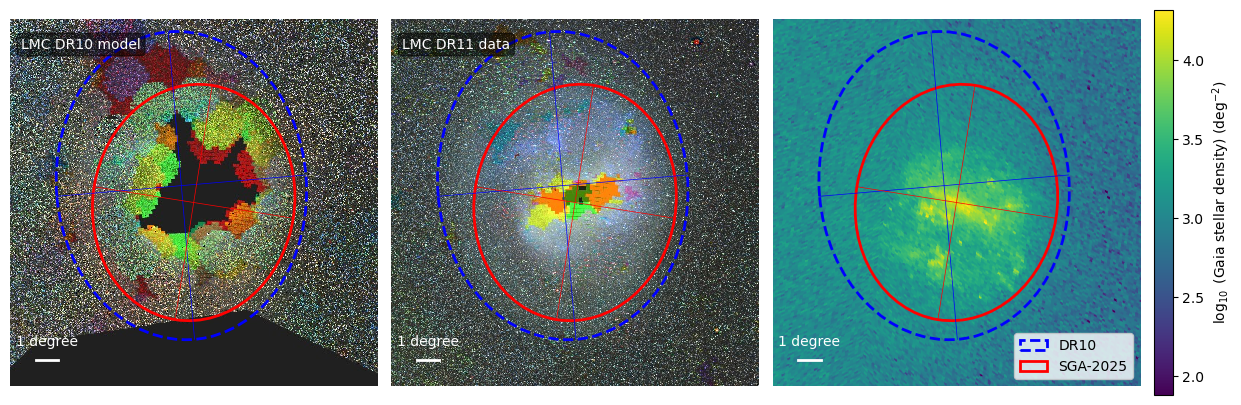

In [13]:
pixscale = 120. # [arcsec/pixel]
width = 500
xyinit = (width / 2., width / 2.)

name = 'LMC'
geo = (ra_lmc, dec_lmc, 645.65*60., 0.85, 171.) # (diam/arcsec, ba, pa)
geo_dr10 = (82.5, -69.0, 7. * 2 * 3600., 0.81, 184.9) # https://github.com/legacysurvey/legacypipe/pull/701

dd = display_clouds(name, geo, geo_dr10, gaia_lmc, pixscale=pixscale)

Wrote /global/cfs/cdirs/desicollab/users/ioannis/SGA/2025/parent/clouds/smc.png


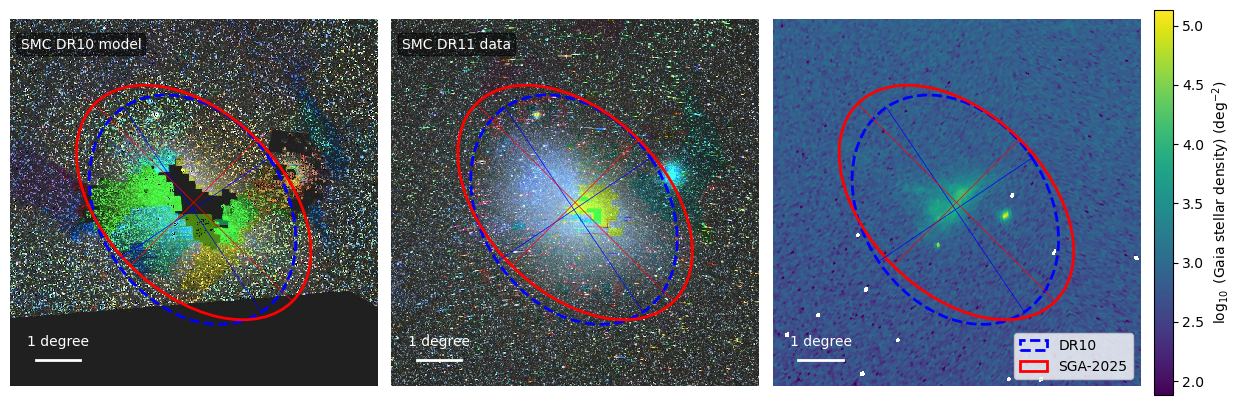

In [14]:
pixscale = 60. # [arcsec/pixel]
width = 500
xyinit = (width / 2., width / 2.)

name = 'SMC'
geo = (ra_smc, dec_smc, 380.19 * 60., 0.64, 45.) # (diam/arcsec, ba, pa)
geo_dr10 = (13.3, -73.0, 2.8 * 2. * 3600., 0.75, 34.) # https://github.com/legacysurvey/legacypipe/pull/701

dd = display_clouds(name, geo, geo_dr10, gaia_smc, pixscale=pixscale)